In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.utils import resample
from sklearn import linear_model, tree, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, confusion_matrix, recall_score, precision_score, classification_report
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from prettytable import PrettyTable
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
%matplotlib inline

ModuleNotFoundError: No module named 'prettytable'

In [3]:
df = pd.read_csv('aggregate.csv', encoding = "ISO-8859-1")

In [4]:
# create total keyword count column and split keyword_count into many columns
for i in range(len(df)):
    keywords = ast.literal_eval(df.at[i, 'keyword_count'])
    df.at[i, "keyword_total"] = sum(keywords.values())
    for word in keywords:
        df.at[i, word] = keywords[word]

In [7]:
# Prep dataframes for models
X = df.drop(['business_id', 'address', 'name', 'demerit', 'grade', 'inspection_fail_count', 'inspection_fail_indicator', 'keyword_count'], axis=1)
Y_categorize = df[['inspection_fail_indicator']]
Y_regression = df[['inspection_fail_count']]
# Up-sample Minority Class for Y_categorize
df_majority = df[df.inspection_fail_indicator==1]
df_minority = df[df.inspection_fail_indicator==0]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,      # sample with replacement
                                 n_samples=7987,    # to match majority class
                                 random_state=23)   # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
# Prep up-sampled dataframes for models
Xup = df.drop(['business_id', 'address', 'name', 'demerit', 'grade', 'inspection_fail_count', 'inspection_fail_indicator', 'keyword_count'], axis=1)
Yup_categorize = df[['inspection_fail_indicator']]
Yup_regression = df[['inspection_fail_count']]

In [5]:
# Random Forest
forest = RandomForestClassifier(min_samples_leaf=10, n_jobs=4, class_weight="balanced", random_state=1123)

In [25]:
# PCA and clustering for exploratory visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import copy

def pca_(X_train):
    X = copy.deepcopy(X_train)
    # standardize data prior to PCA
    scaler = StandardScaler()
    scaler.fit_transform(X)
    # SVD-based PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(X)
    print("Explained variance ratio (3 principal components):", pca.explained_variance_ratio_)
    print("Reduced dimension shape:", pca_result.shape)    
    return pca_result
X_transformed = pca_(X)

Explained variance ratio (3 principal components): [ 0.98817602  0.01047213  0.00112705]
Reduced dimension shape: (9640, 3)


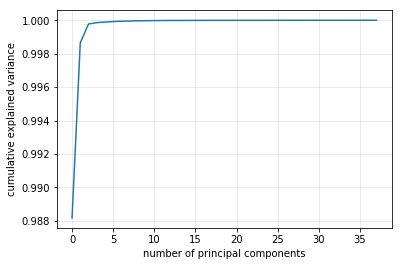

In [20]:
def plot_explained_variance():
    pca = PCA(38)
    pca_full = pca.fit(X)
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
    plt.xlabel("number of principal components")
    plt.ylabel("cumulative explained variance")
    plt.grid(color='grey',linestyle='-',alpha=0.2)
    plt.show()
plot_explained_variance()

In [36]:
(copy.deepcopy(Y_categorize)).dropna

<bound method DataFrame.dropna of       inspection_fail_indicator
0                             1
1                             1
2                             1
3                             1
4                             1
5                             1
6                             1
7                             1
8                             1
9                             1
10                            0
11                            1
12                            1
13                            1
14                            1
15                            0
16                            1
17                            1
18                            1
19                            0
20                            1
21                            1
22                            1
23                            1
24                            1
25                            1
26                            1
27                            1
28                            1
29    

In [32]:
# project data into the dimension of first 2 principal components
def plot_principal_components(pca_result, Y_train):
    plt.figure(figsize=(10,6))
    plt.scatter(pca_result[:3000, 0],
                pca_result[:3000, 1],
                c=Y_train[:3000],
                edgecolor='none', alpha=0.5,
                cmap=plt.get_cmap('jet',10), s=5)
    plt.colorbar()    
Y_transformed = copy.deepcopy(Y_categorize).dropna
plot_principal_components(X_transformed, copy.deepcopy(Y_categorize).dropna)


TypeError: 'method' object is not subscriptable

In [6]:
############
##  Demo  ##
############

# demo data
austin_df = pd.read_csv('austin.csv')
Xaustin = austin_df.drop(['name', 'address', 'inspection_fail_indicator'], axis=1)
Yaustin = austin_df[['inspection_fail_indicator']]

In [14]:
# Fit model and predict Austin Restaurants
forest.fit(X, np.ravel(Y_categorize))
predaustin = forest.predict(Xaustin)
print("Random Forest Classification Report\n", classification_report(Yaustin, predaustin))

Random Forest Classification Report
              precision    recall  f1-score   support

          0       0.75      0.60      0.67         5
          1       0.67      0.80      0.73         5

avg / total       0.71      0.70      0.70        10



In [20]:
# Results table
wrong = []
for i in range(len(predaustin)):
    if (predaustin[i] == np.ravel(Yaustin)[i]):
        wrong.append(" ")
    else:
        wrong.append()"X"
tabl = PrettyTable()
tabl.add_column("Restaurant", austin_df["name"])
tabl.add_column("Truth", np.ravel(Yaustin))
tabl.add_column("Pred", predaustin)
tabl.add_column("Wrong", wrong)
print(tabl, "\n*1 = Failed inspection")

IndexError: list assignment index out of range